In [1]:
import os 
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
### Open file
file_to_use = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\data files\\distractor paper data only\\Mojo\\1369702.mat'
f = scipy.io.loadmat(file_to_use) #put in the same path

In [3]:
### Each column is one trial
df_spike_time=pd.DataFrame(f['data']['spikes'][0][0][0][0][:, :])
df_spike_time.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]
### Each column is one trial
df_spikes_trial1 = df_spike_time.iloc[4:, 0] #remove the first 4 rows, no spikes (this data frame)
df_spikes_trial1 ##spike times of the first trial

4      13.000000
5      85.875000
6     155.104167
7     196.333333
8     226.854167
         ...    
72           NaN
73           NaN
74           NaN
75           NaN
76           NaN
Name: 0, Length: 73, dtype: float64

In [4]:
## Puedes mirarte este tutorial, es donde lo aprendí yo:
## https://elephant.readthedocs.io/en/latest/tutorials/statistics.html

In [5]:
#### Necesitas estas librerías!
### Elephant --> https://elephant.readthedocs.io/en/latest/tutorials/statistics.html
### neo --> https://neo.readthedocs.io/en/stable/install.html

from neo.core import SpikeTrain
from quantities import ms, s, Hz
from elephant.statistics import mean_firing_rate
from elephant.statistics import time_histogram, instantaneous_rate
from elephant.kernels import GaussianKernel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
### Spike times

In [7]:
times_spikes= df_spikes_trial1.values # get trial spike times
times_spikes = times_spikes[times_spikes<9999] ##remove nans in the trial (at the end) Probably you will not need this
times_spikes

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


array([  13.        ,   85.875     ,  155.10416667,  196.33333333,
        226.85416667,  270.83333333,  353.54166667,  381.52083333,
        615.6875    ,  627.52083333,  652.83333333,  679.85416667,
        744.25      ,  823.85416667,  845.52083333,  895.54166667,
        924.02083333,  943.14583333,  958.89583333,  976.75      ,
        994.95833333, 1001.77083333, 1023.58333333, 1031.72916667,
       1046.08333333, 1075.9375    , 1092.72916667, 1107.33333333,
       1132.52083333, 1209.33333333, 1248.5       , 1264.77083333,
       2441.27083333, 2747.70833333, 2797.04166667, 2802.08333333,
       2836.64583333])

In [8]:
stop_time =  times_spikes.max() ##Needed to make the spiketrain
### start_time = 0*ms #has de ponerlo si no se empieza a samplear alineado al mismo momento, default es 0

In [9]:
### Ahora pones los spiketimes en el formato de spiketrain (necesario para siguientes pasos)
spiketrain1 = SpikeTrain(times_spikes, units=ms, t_stop=stop_time) #spiketrain

In [10]:
histogram_rate = time_histogram([spiketrain1], 2*ms, output='rate') ##sampling rate de 2ms (bining) for example, increase for less temporal resolution

C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


In [11]:
###### Convoluted firing rate (yo usé el Gaussian para replicar los resultados de un paper, hay mas!)
gaus_rate = instantaneous_rate(spiketrain1, sampling_period=2*ms, kernel=GaussianKernel(15*ms)) #s.d of Suzuki & Gottlieb 
times_ = gaus_rate.times.rescale(ms)
firing_gauss = gaus_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()


df_trial = pd.DataFrame({'times':times_, 'firing_gauss':firing_gauss}) #dataframe con times y firing

In [12]:
df_trial

,firing_gauss,times
0,0.020326,0.0
1,0.022215,2.0
2,0.023852,4.0
3,0.025159,6.0
4,0.026070,8.0
...,...,...
1413,0.031990,2826.0
1414,0.031481,2828.0
1415,0.031011,2830.0
1416,0.030482,2832.0


In [13]:
##otro ejemplo de kernel con otro sampling period
inst_rate = instantaneous_rate(spiketrain1, sampling_period=25*ms)
times_ = inst_rate.times.rescale(ms)
firing_kernel2 = inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()

In [83]:
#Plot con todo

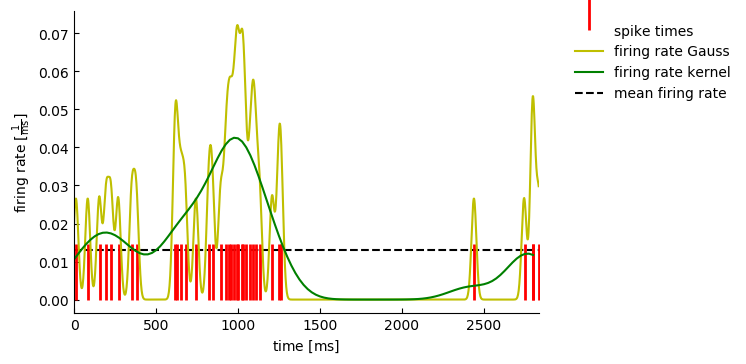

In [84]:
plt.figure(dpi=100) #dpi=150

# plotting the original spiketrain
plt.plot(spiketrain1, [0]*len(spiketrain1), 'r', marker=2, ms=40, markeredgewidth=2, lw=0, label='spike times')

# mean firing rate
plt.hlines(mean_firing_rate(spiketrain1), xmin=spiketrain1.t_start, xmax=spiketrain1.t_stop, linestyle='--', label='mean firing rate')

# convoluted firing rate Gaussian Kernel
plt.plot(gaus_rate.times.rescale(ms), gaus_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), color='y', label='firing rate Gauss')

# convoluted firing rate Other Kernel
plt.plot(inst_rate.times.rescale(ms), inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), color='g', label='firing rate kernel')




# axis labels and legend
plt.xlabel('time [{}]'.format(spiketrain1.times.dimensionality.latex))
plt.ylabel('firing rate [{}]'.format(histogram_rate.dimensionality.latex))
plt.xlim(spiketrain1.t_start, spiketrain1.t_stop)
plt.legend( frameon=False, bbox_to_anchor=(1.05, 1))
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()

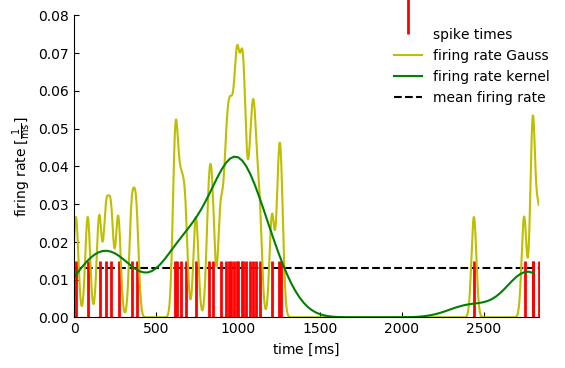

In [16]:
plt.figure(dpi=100) #dpi=150

# plotting the original spiketrain
plt.plot(spiketrain1, [0]*len(spiketrain1), 'r', marker=2, ms=40, markeredgewidth=2, lw=0, label='spike times')

# mean firing rate
plt.hlines(mean_firing_rate(spiketrain1), xmin=spiketrain1.t_start, xmax=spiketrain1.t_stop, linestyle='--', label='mean firing rate')

# convoluted firing rate Gaussian Kernel
plt.plot(gaus_rate.times.rescale(ms), gaus_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), color='y', label='firing rate Gauss')

# convoluted firing rate Other Kernel
plt.plot(inst_rate.times.rescale(ms), inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), color='g', label='firing rate kernel')




# axis labels and legend
plt.xlabel('time [{}]'.format(spiketrain1.times.dimensionality.latex))
plt.ylabel('firing rate [{}]'.format(histogram_rate.dimensionality.latex))
plt.xlim(spiketrain1.t_start, spiketrain1.t_stop)
plt.legend( frameon=False, bbox_to_anchor=(1.05, 1))
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.ylim(0, 0.08)

plt.savefig('C:\\Users\\David\\Desktop\\single_neuron_analysis_Gottlieb.svg', transparent=True )